# **BUILDING A MODEL FOR  PREDICTING THE BIOACTIVITY  OF DRUG AGAINST COX2 enzyme**

# INTRODUCTION

Project Title: Prediction of Drug Bioactivity (IC50) against Cyclooxygenase-2 (COX-2) using RandomForestRegressor
Introduction:
Cyclooxygenase-2 (COX-2) is an enzyme that plays a significant role in the inflammation process by catalyzing the production of prostaglandins. Overexpression of COX-2 is associated with various inflammatory diseases, making it a critical target for anti-inflammatory drugs. The bioactivity of these drugs is often measured by their IC50 values, which indicate the concentration required to inhibit COX-2 activity by 50%. Machine learning models, such as RandomForestRegressor, can be employed to predict these IC50 values based on molecular descriptors, aiding in the rapid screening and optimization of potential anti-inflammatory agents.

Aim:
The aim of this project is to develop a RandomForestRegressor model to predict the IC50 values of drugs against the COX-2 enzyme, thereby facilitating the identification and optimization of effective anti-inflammatory agents.

Objective:
To preprocess the dataset containing molecular descriptors and IC50 values for drugs targeting COX-2.
To build and train a RandomForestRegressor model using Python to accurately predict IC50 values.
To evaluate the model's performance using metrics such as mean squared error (MSE), R-squared (R²), and mean absolute error (MAE).


In [1]:
# Importing the libraries
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
from chembl_webresource_client.new_client import new_client
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import r2_score
import pickle


CHOOSING THE TARGET PROTEIN


In [2]:

targets_api = new_client.target
targets = targets_api.get(target_components__accession='P28845').only("target_chembl_id", "organism", "pref_name", "target_type")
print(f'The type of the targets is "{type(targets)}"')
targets = pd.DataFrame.from_records(targets)
print('targets')
display(targets)
selected_target = targets.target_chembl_id[0]
print(f'The selected target is "{selected_target}"')
display(selected_target)

The type of the targets is "<class 'chembl_webresource_client.query_set.QuerySet'>"
targets


,organism,pref_name,target_chembl_id,target_type
0,Homo sapiens,11-beta-hydroxysteroid dehydrogenase 1,CHEMBL4235,SINGLE PROTEIN
1,Homo sapiens,11-beta-hydroxysteroid dehydrogenase 1,CHEMBL4235,SINGLE PROTEIN
2,Homo sapiens,11-beta-hydroxysteroid dehydrogenase,CHEMBL3542430,PROTEIN FAMILY


The selected target is "CHEMBL4235"


'CHEMBL4235'

In [4]:

# serch for target protein

target = new_client.target
target_query = target.search('cox2').only(['target_chembl_id','pref_name','organism','target_type'])
df = pd.DataFrame(target_query)
display(df)

,organism,pref_name,target_chembl_id,target_type
0,Ovis aries,Cytochrome c oxidase subunit 2,CHEMBL1250404,SINGLE PROTEIN
1,Homo sapiens,Cyclooxygenase-2,CHEMBL230,SINGLE PROTEIN
2,Rattus norvegicus,Cyclooxygenase-2,CHEMBL2977,SINGLE PROTEIN
3,Oryctolagus cuniculus,Prostaglandin G/H synthase 2,CHEMBL1293198,SINGLE PROTEIN
4,Homo sapiens,Cytochrome c oxidase subunit 2,CHEMBL6174,SINGLE PROTEIN
5,Bos taurus,Cyclooxygenase-2,CHEMBL3331,SINGLE PROTEIN
6,Mus musculus,Cyclooxygenase-2,CHEMBL4321,SINGLE PROTEIN
7,Ovis aries,Cyclooxygenase-2,CHEMBL4102,SINGLE PROTEIN
8,Cavia porcellus,Prostaglandin G/H synthase 2,CHEMBL4523261,SINGLE PROTEIN
9,Homo sapiens,Cyclooxygenase,CHEMBL2094253,PROTEIN FAMILY


In [5]:
selected_target = df.target_chembl_id[1]
selected_target

'CHEMBL230'

COLLECTING DATAS RELATED TO THE CHOOSEN TARGETED PROTEIN


In [6]:
dict_df = new_client.activity.filter(target_chembl_id=selected_target, type="IC50",relation="=",assay_type="B").only(["molecule_chembl_id","canonical_smiles","standard_value","standard_units"])
df = pd.DataFrame.from_dict(dict_df)
display(df)

,canonical_smiles,molecule_chembl_id,standard_units,standard_value,units,value
0,Cc1ccc(-c2ccc(S(C)(=O)=O)cc2)n1-c1ccccc1,CHEMBL297008,nM,60.0,uM,0.06
1,Cc1c(C=O)cc(-c2ccc(S(C)(=O)=O)cc2)n1-c1ccc(F)cc1,CHEMBL289813,nM,3230.0,uM,3.23
2,Cc1c(COc2cccc(Cl)c2)cc(-c2ccc(S(C)(=O)=O)cc2)n...,CHEMBL43736,nM,80.0,uM,0.08
3,Fc1ccc(-c2[nH]c(-c3ccc(F)cc3)c3c2C2CCC3CC2)cc1,CHEMBL140167,nM,0.12,nM,0.12
4,CC(=O)c1cc(-c2ccc(S(C)(=O)=O)cc2)n(-c2ccc(F)cc...,CHEMBL44290,nM,1610.0,uM,1.61
...,...,...,...,...,...,...
4793,Cc1c(Nc2ccc(S(=O)(=O)N3CCN(C)CC3)cc2F)nc2ccc(N...,CHEMBL4758581,µM,0.8,µM,0.8
4794,C[C@H](C(=O)OC(Cn1ccnc1)c1ccc(F)cc1)c1ccc(-c2c...,CHEMBL5220891,nM,3760.0,uM,3.76
4795,C[C@H](C(=O)N(C)CC(O)(Cn1ccnc1)c1ccc(Cl)cc1)c1...,CHEMBL5219013,nM,2290.0,uM,2.29
4796,C[C@H](C(=O)N(C)CC(O)(Cn1ccnc1)c1ccc(Cl)cc1Cl)...,CHEMBL5219227,nM,1930.0,uM,1.93


CLEANING THE DATA

In [7]:
df = df.dropna()
display(df)
df.to_csv('cox2.csv', index=False)

,canonical_smiles,molecule_chembl_id,standard_units,standard_value,units,value
0,Cc1ccc(-c2ccc(S(C)(=O)=O)cc2)n1-c1ccccc1,CHEMBL297008,nM,60.0,uM,0.06
1,Cc1c(C=O)cc(-c2ccc(S(C)(=O)=O)cc2)n1-c1ccc(F)cc1,CHEMBL289813,nM,3230.0,uM,3.23
2,Cc1c(COc2cccc(Cl)c2)cc(-c2ccc(S(C)(=O)=O)cc2)n...,CHEMBL43736,nM,80.0,uM,0.08
3,Fc1ccc(-c2[nH]c(-c3ccc(F)cc3)c3c2C2CCC3CC2)cc1,CHEMBL140167,nM,0.12,nM,0.12
4,CC(=O)c1cc(-c2ccc(S(C)(=O)=O)cc2)n(-c2ccc(F)cc...,CHEMBL44290,nM,1610.0,uM,1.61
...,...,...,...,...,...,...
4793,Cc1c(Nc2ccc(S(=O)(=O)N3CCN(C)CC3)cc2F)nc2ccc(N...,CHEMBL4758581,µM,0.8,µM,0.8
4794,C[C@H](C(=O)OC(Cn1ccnc1)c1ccc(F)cc1)c1ccc(-c2c...,CHEMBL5220891,nM,3760.0,uM,3.76
4795,C[C@H](C(=O)N(C)CC(O)(Cn1ccnc1)c1ccc(Cl)cc1)c1...,CHEMBL5219013,nM,2290.0,uM,2.29
4796,C[C@H](C(=O)N(C)CC(O)(Cn1ccnc1)c1ccc(Cl)cc1Cl)...,CHEMBL5219227,nM,1930.0,uM,1.93


In [8]:
import pandas as pd
df = pd.read_csv('cox2.csv')
print(f'unique canonical: {len(df.canonical_smiles.unique())}')
df.drop_duplicates(subset=['canonical_smiles'],inplace=True)
df3 = df[['molecule_chembl_id','canonical_smiles','standard_value']]
df3 = df3.reset_index(drop=True)
display(df3)

unique canonical: 3712


,molecule_chembl_id,canonical_smiles,standard_value
0,CHEMBL297008,Cc1ccc(-c2ccc(S(C)(=O)=O)cc2)n1-c1ccccc1,60.00
1,CHEMBL289813,Cc1c(C=O)cc(-c2ccc(S(C)(=O)=O)cc2)n1-c1ccc(F)cc1,3230.00
2,CHEMBL43736,Cc1c(COc2cccc(Cl)c2)cc(-c2ccc(S(C)(=O)=O)cc2)n...,80.00
3,CHEMBL140167,Fc1ccc(-c2[nH]c(-c3ccc(F)cc3)c3c2C2CCC3CC2)cc1,0.12
4,CHEMBL44290,CC(=O)c1cc(-c2ccc(S(C)(=O)=O)cc2)n(-c2ccc(F)cc...,1610.00
...,...,...,...
3707,CHEMBL5183018,Cn1ccc2cc(CCCO)c(O)c(C(=O)OCC(F)(F)F)c21,237100.00
3708,CHEMBL4758581,Cc1c(Nc2ccc(S(=O)(=O)N3CCN(C)CC3)cc2F)nc2ccc(N...,0.80
3709,CHEMBL5220891,C[C@H](C(=O)OC(Cn1ccnc1)c1ccc(F)cc1)c1ccc(-c2c...,3760.00
3710,CHEMBL5219013,C[C@H](C(=O)N(C)CC(O)(Cn1ccnc1)c1ccc(Cl)cc1)c1...,2290.00


In [9]:
df_no_smiles = df3.drop(columns='canonical_smiles')
df_no_smiles

,molecule_chembl_id,standard_value
0,CHEMBL297008,60.00
1,CHEMBL289813,3230.00
2,CHEMBL43736,80.00
3,CHEMBL140167,0.12
4,CHEMBL44290,1610.00
...,...,...
3707,CHEMBL5183018,237100.00
3708,CHEMBL4758581,0.80
3709,CHEMBL5220891,3760.00
3710,CHEMBL5219013,2290.00


In [10]:
smiles = []

for i in df3.canonical_smiles.tolist():
  cpd = str(i).split('.')
  cpd_longest = max(cpd, key = len)
  smiles.append(cpd_longest)

smiles = pd.Series(smiles, name = 'canonical_smiles')

In [11]:
df_clean_smiles = pd.concat([df_no_smiles,smiles], axis=1)
df_clean_smiles

,molecule_chembl_id,standard_value,canonical_smiles
0,CHEMBL297008,60.00,Cc1ccc(-c2ccc(S(C)(=O)=O)cc2)n1-c1ccccc1
1,CHEMBL289813,3230.00,Cc1c(C=O)cc(-c2ccc(S(C)(=O)=O)cc2)n1-c1ccc(F)cc1
2,CHEMBL43736,80.00,Cc1c(COc2cccc(Cl)c2)cc(-c2ccc(S(C)(=O)=O)cc2)n...
3,CHEMBL140167,0.12,Fc1ccc(-c2[nH]c(-c3ccc(F)cc3)c3c2C2CCC3CC2)cc1
4,CHEMBL44290,1610.00,CC(=O)c1cc(-c2ccc(S(C)(=O)=O)cc2)n(-c2ccc(F)cc...
...,...,...,...
3707,CHEMBL5183018,237100.00,Cn1ccc2cc(CCCO)c(O)c(C(=O)OCC(F)(F)F)c21
3708,CHEMBL4758581,0.80,Cc1c(Nc2ccc(S(=O)(=O)N3CCN(C)CC3)cc2F)nc2ccc(N...
3709,CHEMBL5220891,3760.00,C[C@H](C(=O)OC(Cn1ccnc1)c1ccc(F)cc1)c1ccc(-c2c...
3710,CHEMBL5219013,2290.00,C[C@H](C(=O)N(C)CC(O)(Cn1ccnc1)c1ccc(Cl)cc1)c1...


CREATING A NEW COLUMN 'Bioactivity_threshold'


In [12]:
bioactivity_threshold = []
for i in df_clean_smiles['standard_value']:
  if float(i) >= 10000:
    bioactivity_threshold.append("inactive")
  elif float(i) <= 1000:
    bioactivity_threshold.append("active")
  else:
    bioactivity_threshold.append("intermediate")

IC50 Count
class
active          1940
intermediate    1049
inactive         723
Name: count, dtype: int64


/tmp/ipykernel_547/1664202038.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='class', data=df5, palette=colors)


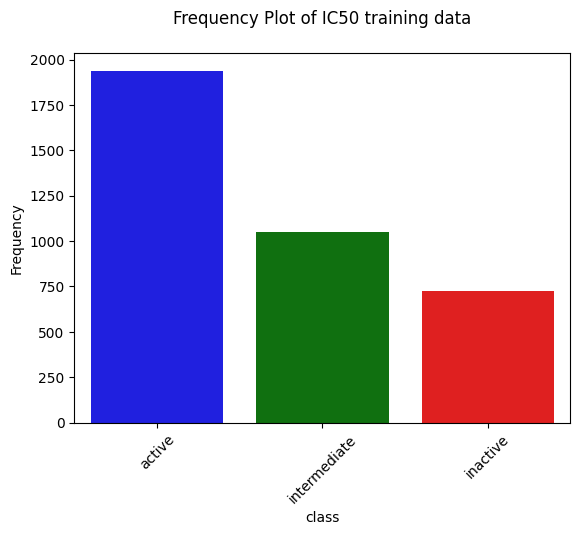

In [13]:
bioactivity_class = pd.Series(bioactivity_threshold, name='class')
df5 = pd.concat([df_clean_smiles, bioactivity_class], axis=1)
# df5

print('IC50 Count')
gender_freq = df5['class'].value_counts()
# gender_freq
print(gender_freq)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

value_counts = df5['class'].value_counts()

colors = ['blue', 'green', 'red']

sns.countplot(x='class', data=df5, palette=colors)
plt.ylabel('Frequency')
plt.title('Frequency Plot of IC50 training data\n')

plt.xticks(rotation=45)

plt.show()


REMOVING DATAS THAT HAVE INTERMEDIATE AS THEIR BIOACTIVITY


In [14]:
df5 = df5[df5['class']  != 'intermediate']
df5.reset_index(drop=True, inplace= True)

df_clean_smiles = df5

In [15]:
df_clean_smiles

,molecule_chembl_id,standard_value,canonical_smiles,class
0,CHEMBL297008,60.00,Cc1ccc(-c2ccc(S(C)(=O)=O)cc2)n1-c1ccccc1,active
1,CHEMBL43736,80.00,Cc1c(COc2cccc(Cl)c2)cc(-c2ccc(S(C)(=O)=O)cc2)n...,active
2,CHEMBL140167,0.12,Fc1ccc(-c2[nH]c(-c3ccc(F)cc3)c3c2C2CCC3CC2)cc1,active
3,CHEMBL43737,40.00,Cc1ccc(-n2c(C)ccc2-c2ccc(S(C)(=O)=O)cc2)cc1,active
4,CHEMBL43511,14.00,NS(=O)(=O)c1ccc(-n2cccc2-c2ccc(F)cc2)cc1,active
...,...,...,...,...
2658,CHEMBL5200000,40.00,CS(=O)(=O)c1ccc(-c2cc(C(F)(F)F)nc(NCc3ccc([18F...,active
2659,CHEMBL5200454,1.00,CS(=O)(=O)c1ccc(-c2cc(O[11CH3])nc(NCc3cccs3)n2...,active
2660,CHEMBL5191304,187500.00,Cc1cc2ccn(C)c2c(C(=O)OCC(F)(F)F)c1O,inactive
2661,CHEMBL5183018,237100.00,Cn1ccc2cc(CCCO)c(O)c(C(=O)OCC(F)(F)F)c21,inactive


CALCULATION OF pIC50


In [16]:
def pIC50(input):
    pIC50 = []

    for i in input['standard_value_norm']:
        molar = i*(10**-9) 
        pIC50.append(-np.log10(molar))

    input['pIC50'] = pIC50
    x = input.drop('standard_value_norm', axis=1)
        
    return x

def norm_value(input):
    norm = []

    for i in input['standard_value']:
        if i > 100000000:
          i = 100000000
        norm.append(i)

    input['standard_value_norm'] = norm
    x = input.drop('standard_value', axis=1)
        
    return x

In [17]:
df_norm = norm_value(df_clean_smiles)
df_norm

,molecule_chembl_id,canonical_smiles,class,standard_value_norm
0,CHEMBL297008,Cc1ccc(-c2ccc(S(C)(=O)=O)cc2)n1-c1ccccc1,active,60.00
1,CHEMBL43736,Cc1c(COc2cccc(Cl)c2)cc(-c2ccc(S(C)(=O)=O)cc2)n...,active,80.00
2,CHEMBL140167,Fc1ccc(-c2[nH]c(-c3ccc(F)cc3)c3c2C2CCC3CC2)cc1,active,0.12
3,CHEMBL43737,Cc1ccc(-n2c(C)ccc2-c2ccc(S(C)(=O)=O)cc2)cc1,active,40.00
4,CHEMBL43511,NS(=O)(=O)c1ccc(-n2cccc2-c2ccc(F)cc2)cc1,active,14.00
...,...,...,...,...
2658,CHEMBL5200000,CS(=O)(=O)c1ccc(-c2cc(C(F)(F)F)nc(NCc3ccc([18F...,active,40.00
2659,CHEMBL5200454,CS(=O)(=O)c1ccc(-c2cc(O[11CH3])nc(NCc3cccs3)n2...,active,1.00
2660,CHEMBL5191304,Cc1cc2ccn(C)c2c(C(=O)OCC(F)(F)F)c1O,inactive,187500.00
2661,CHEMBL5183018,Cn1ccc2cc(CCCO)c(O)c(C(=O)OCC(F)(F)F)c21,inactive,237100.00


In [18]:
df_norm = df_norm[df_norm.standard_value_norm > 0]
df_norm.reset_index(drop=True, inplace=True)

In [19]:
df_norm.standard_value_norm.describe()

count    2.656000e+03
mean     4.388630e+04
std      1.167310e+06
min      6.000000e-03
25%      5.100000e+01
50%      3.000000e+02
75%      1.100000e+04
max      6.000000e+07
Name: standard_value_norm, dtype: float64

In [20]:
df_final = pIC50(df_norm)
df_final


/tmp/ipykernel_547/410065675.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input['pIC50'] = pIC50


,molecule_chembl_id,canonical_smiles,class,pIC50
0,CHEMBL297008,Cc1ccc(-c2ccc(S(C)(=O)=O)cc2)n1-c1ccccc1,active,7.221849
1,CHEMBL43736,Cc1c(COc2cccc(Cl)c2)cc(-c2ccc(S(C)(=O)=O)cc2)n...,active,7.096910
2,CHEMBL140167,Fc1ccc(-c2[nH]c(-c3ccc(F)cc3)c3c2C2CCC3CC2)cc1,active,9.920819
3,CHEMBL43737,Cc1ccc(-n2c(C)ccc2-c2ccc(S(C)(=O)=O)cc2)cc1,active,7.397940
4,CHEMBL43511,NS(=O)(=O)c1ccc(-n2cccc2-c2ccc(F)cc2)cc1,active,7.853872
...,...,...,...,...
2651,CHEMBL5200000,CS(=O)(=O)c1ccc(-c2cc(C(F)(F)F)nc(NCc3ccc([18F...,active,7.397940
2652,CHEMBL5200454,CS(=O)(=O)c1ccc(-c2cc(O[11CH3])nc(NCc3cccs3)n2...,active,9.000000
2653,CHEMBL5191304,Cc1cc2ccn(C)c2c(C(=O)OCC(F)(F)F)c1O,inactive,3.726999
2654,CHEMBL5183018,Cn1ccc2cc(CCCO)c(O)c(C(=O)OCC(F)(F)F)c21,inactive,3.625068


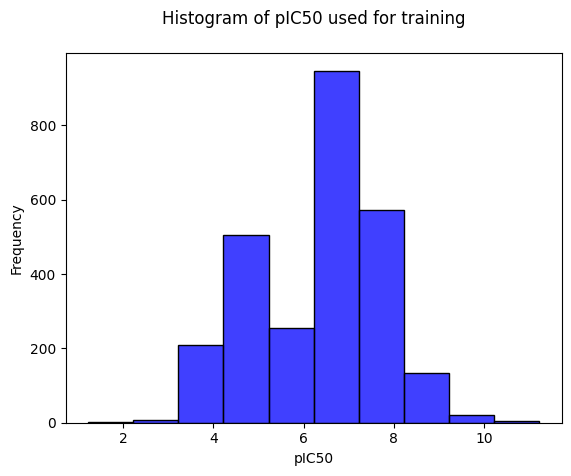

In [21]:
sns.histplot(data = df_final, x = df_final.pIC50, bins=10, color='blue', edgecolor='black')
plt.xlabel('pIC50')
plt.ylabel('Frequency')
plt.title('Histogram of pIC50 used for training\n')
plt.show()

COVERTING EACH CONANICAL SMILE TO FINGERPRINT NEEDED FOR TRAINING THE MODEL

In [22]:
smiles = df_final['canonical_smiles'].to_list()
embedding = []
for smile in smiles:    
    molecule = Chem.MolFromSmiles(smile)
    fingerprint = AllChem.GetMorganFingerprintAsBitVect(molecule, radius=2, nBits=2048)
    fingerprint_array = np.array(fingerprint)    
    embedding.append(fingerprint_array)
df = pd.DataFrame(embedding)
df1 = df_final[['molecule_chembl_id','pIC50']]
df = pd.concat([df1, df], axis=1)

In [23]:
display(df)

,molecule_chembl_id,pIC50,0,1,2,3,4,5,6,7,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,CHEMBL297008,7.221849,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,CHEMBL43736,7.096910,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,CHEMBL140167,9.920819,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,CHEMBL43737,7.397940,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,CHEMBL43511,7.853872,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2651,CHEMBL5200000,7.397940,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2652,CHEMBL5200454,9.000000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2653,CHEMBL5191304,3.726999,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2654,CHEMBL5183018,3.625068,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
dataset3 = df.drop(columns=['molecule_chembl_id'])
dataset3

,pIC50,0,1,2,3,4,5,6,7,8,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,7.221849,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7.096910,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,9.920819,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,7.397940,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,7.853872,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2651,7.397940,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2652,9.000000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2653,3.726999,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2654,3.625068,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


LABELING THE DATA

In [25]:
X = dataset3.drop('pIC50', axis=1)
y = dataset3.pIC50
display(X, y)

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2651,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2652,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2653,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2654,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


0       7.221849
1       7.096910
2       9.920819
3       7.397940
4       7.853872
          ...   
2651    7.397940
2652    9.000000
2653    3.726999
2654    3.625068
2655    9.096910
Name: pIC50, Length: 2656, dtype: float64

SPLITING THE DATAS

In [43]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((2124, 2048), (2124,), (532, 2048), (532,))

USING LAZY PREDICT TO FIND THE BEST MODEL

In [27]:
import lazypredict
from lazypredict.Supervised import LazyRegressor

In [28]:
reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)

In [30]:
models, predictions = reg.fit(X_train, X_test, Y_train, Y_test)

'tuple' object has no attribute '__name__'
Invalid Regressor(s)


  0%|          | 0/42 [00:00<?, ?it/s]

 76%|███████▌  | 32/42 [33:39<01:18,  7.89s/it]   

QuantileRegressor model failed to execute
Solver interior-point is not anymore available in SciPy >= 1.11.0.


 98%|█████████▊| 41/42 [45:08<00:15, 15.29s/it] 

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015631 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2187
[LightGBM] [Info] Number of data points in the train set: 2124, number of used features: 729
[LightGBM] [Info] Start training from score 6.314530


100%|██████████| 42/42 [45:09<00:00, 64.51s/it]


In [31]:
models

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
LinearRegression,355572894242260867667197952.00,-1015826893720357375683067904.00,44323115434455.20,6.88
TransformedTargetRegressor,355572894242260867667197952.00,-1015826893720357375683067904.00,44323115434455.20,6.25
RANSACRegressor,166580465900104929826045952.00,-475899372449075708389490688.00,30337374434383.72,622.04
Lars,13856093522415401182429184.00,-39585110872889193727524864.00,8749562919851.17,5.43
SGDRegressor,155400806578122896965632.00,-443960496382320968728576.00,926600627349.19,0.83
KernelRidge,9.48,-23.23,6.85,1.65
GaussianProcessRegressor,8.16,-19.45,6.29,114.88
LinearSVR,2.35,-2.86,2.73,15.51
Ridge,2.03,-1.94,2.38,1.45


CHOOSING THE BEST PARAMETER VALUE FOR THE MODEL

In [34]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import make_scorer
from scipy.stats import pearsonr

def pearson_corr(y_true, y_pred):
    return pearsonr(y_true, y_pred)[0]

pearson_scorer = make_scorer(pearson_corr)
X = dataset3.drop('pIC50', axis=1)
y = dataset3['pIC50']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
models = {
    RandomForestRegressor(): {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, None]
    },
    GradientBoostingRegressor(): {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1]
    },
    LinearRegression(): {
    },
    SVR(): {
        'C': [0.1, 1, 10],
        'kernel': ['rbf', 'linear']
    },
    KNeighborsRegressor(): {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance']
    }
}

for model, param_grid in models.items():
    grid = GridSearchCV(model, param_grid, cv=5, scoring=pearson_scorer, n_jobs=-1)
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)
    pearson_corr, _ = pearsonr(y_pred, y_test)
    print(f"Best model: {best_model}")
    print(f"Best Pearson Correlation Coefficient: {pearson_corr}")


Best model: RandomForestRegressor()
Best Pearson Correlation Coefficient: 0.7602848202924862
Best model: GradientBoostingRegressor(n_estimators=200)
Best Pearson Correlation Coefficient: 0.6909376455146213
Best model: LinearRegression()
Best Pearson Correlation Coefficient: -0.0057379398390743136
Best model: SVR(C=10)
Best Pearson Correlation Coefficient: 0.7813639161563637
Best model: KNeighborsRegressor(n_neighbors=3, weights='distance')
Best Pearson Correlation Coefficient: 0.7598695769523627


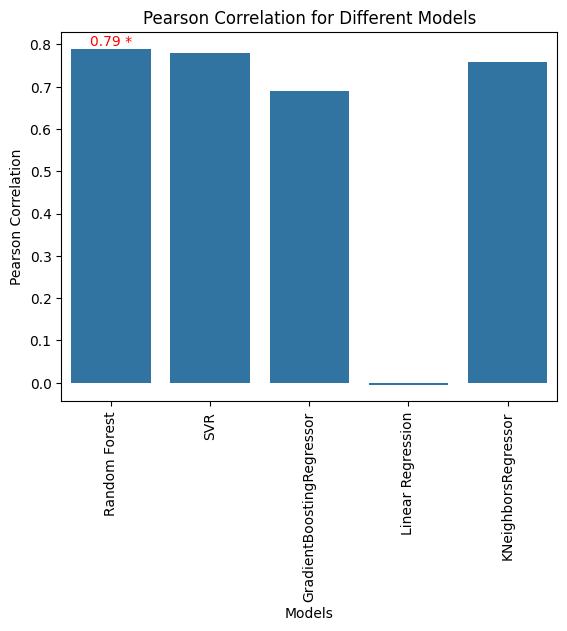

In [37]:
models = ['Random Forest', 'SVR', 'GradientBoostingRegressor', 'Linear Regression', 'KNeighborsRegressor']
pearson_corr = [0.79, 0.78, 0.69, -0.005, 0.759]
sns.barplot(x=models, y=pearson_corr)
plt.xlabel('Models')
plt.ylabel('Pearson Correlation')
plt.title('Pearson Correlation for Different Models')
plt.xticks(rotation=90)
highest_corr = max(pearson_corr)
highest_index = pearson_corr.index(highest_corr)
plt.annotate(f'{highest_corr} *', xy=(highest_index, highest_corr), xytext=(0, 2), textcoords='offset points', ha='center', color='red')

plt.show()





EVALUATING THE PERFORMANCE OF THE MODEL


In [38]:
model = RandomForestRegressor()
num_folds = 10
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)
cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='r2')
print("R-squared scores for each fold:", cv_results)
print("Mean R-squared score:", sum(cv_results)/num_folds)
model.fit(X_train, Y_train)
y_pred = model.predict(X_test)
r2 = r2_score(Y_test, y_pred)
print("R-squared score on the testing set:", r2)
y_pred = np.array(y_pred).flatten()  
y_test = np.array(Y_test).flatten() 
pearson_corr, _ = pearsonr(y_pred, y_test)
print(f"Pearson Correlation Coefficient: {pearson_corr}")


R-squared scores for each fold: [0.52798527 0.5981746  0.50931495 0.58937442 0.62027199 0.49997331
 0.59059817 0.59192957 0.57596659 0.6161071 ]
Mean R-squared score: 0.5719695962206518
R-squared score on the testing set: 0.5454087073681357
Pearson Correlation Coefficient: 0.8647750955360888


Text(0.5, 0, 'Experimental pIC50')

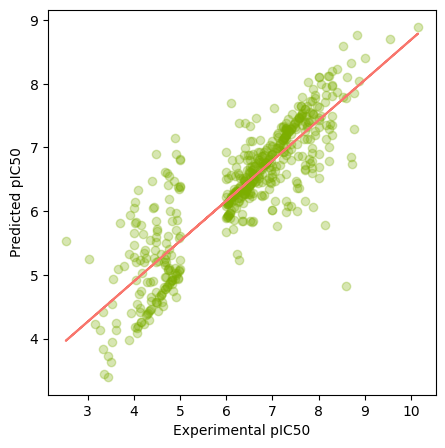

In [39]:
plt.figure(figsize=(5,5))
plt.scatter(x=Y_test, y=y_pred, c="#7CAE00", alpha=0.3)
z = np.polyfit(Y_test, y_pred, 1)
p = np.poly1d(z)

plt.plot(Y_test,p(Y_test),"#F8766D")
plt.ylabel('Predicted pIC50')
plt.xlabel('Experimental pIC50')

SAVING THE MODEL


In [ ]:
pickle.dump(model, open('cox2_model.pkl', 'wb'))